# SHAP values 2020-21

Notebook for digging into any predictions made by the FFS model

## Set-up

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pyarrow.parquet as pq

In [2]:
os.chdir('..')

In [3]:
from src.models.DeepFantasyFootball.make_predictions import DeepFantasyFootball, load_live_data
from src.models.constants import SEASON_ORDER_DICT

Using TensorFlow backend.


In [4]:
pd.options.display.max_columns = None

In [5]:
shap.initjs()

In [6]:
# from src.data.s3_utilities import s3_filesystem

In [7]:
# gw1_predictions = pq.read_table('s3://fpl-analysis-data/gw_predictions/season=2020-21/gw=1/2020-21-1.parquet', filesystem=s3_filesystem).to_pandas()
# gw1_predictions.head()

In [8]:
RANDOM_SEED = 3

## Make predictions

In [9]:
SEASON_ORDER_DICT

{'2011-12': -4,
 '2012-13': -3,
 '2013-14': -2,
 '2014-15': -1,
 '2015-16': 0,
 '2016-17': 1,
 '2017-18': 2,
 '2018-19': 3,
 '2019-20': 4,
 '2020-21': 5}

In [29]:
%%time
live_data = load_live_data()

2020-10-02 16:03:50,122 - Loading historical FFS data
2020-10-02 16:03:54,824 - Loaded historical FFS data of shape (92410, 66)
2020-10-02 16:03:54,825 - Loading latest FFS data
2020-10-02 16:03:54,825 - FFS data for 2020-2021 available
2020-10-02 16:03:54,826 - Working on FINAL_FEATURES_1_DEF
2020-10-02 16:03:56,266 - Finished FINAL_FEATURES_1_DEF
2020-10-02 16:03:56,267 - Working on FINAL_FEATURES_2_DEF
2020-10-02 16:03:57,509 - Finished FINAL_FEATURES_2_DEF
2020-10-02 16:03:57,510 - Working on FINAL_FEATURES_3_DEF
2020-10-02 16:03:58,795 - Finished FINAL_FEATURES_3_DEF
2020-10-02 16:03:58,796 - Working on FINAL_FEATURES_4_DEF
2020-10-02 16:04:00,568 - Finished FINAL_FEATURES_4_DEF
2020-10-02 16:04:00,569 - Working on FINAL_FEATURES_5_DEF
2020-10-02 16:04:01,899 - Finished FINAL_FEATURES_5_DEF
2020-10-02 16:04:01,900 - Working on FINAL_FEATURES_6_DEF
2020-10-02 16:04:03,663 - Finished FINAL_FEATURES_6_DEF
2020-10-02 16:04:03,663 - Working on FINAL_FEATURES_1_FWD
2020-10-02 16:04:04,9

CPU times: user 5.15 s, sys: 938 ms, total: 6.09 s
Wall time: 51.7 s


In [30]:
print(live_data.shape)
live_data.head()

(177793, 66)


,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points,season_order
0,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,2.45,2.41,1.0,0.0,0.0,1.21,0.0,0,0,1,0,0,0,0.0,4
25,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0.0,2.30,2.29,1.0,0.0,0.0,1.34,1.0,0,0,1,0,0,0,0.0,4
50,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.0,10.67,0.09,0.0,0.0,1.0,30.23,1.0,0,0,1,0,0,0,0.0,4
75,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.00,100.0,0.0,100.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0,4,0.0,2.40,2.67,1.0,0.0,0.0,1.14,0.0,1,0,1,0,0,0,1.0,4
100,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.2,0.0,0.0,0.0,0.0,2.0,0.14,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,2.0,0,5,0.0,2.22,1.40,0.0,0.0,0.0,2.26,1.0,0,0,1,0,0,0,1.0,4


In [31]:
# Remove sides relegated in 2019-20
live_data = live_data.copy()[~live_data['team_name'].isin(['Bournemouth', 'Watford', 'Norwich City'])]
# Remove players who are in 2020-21 season but only previously played more than one season ago in the PL
live_data = live_data.copy()[~live_data['name'].isin(['bobby_reid', 'darnell_furlong', 'kyle_bartley'])]

In [32]:
PREVIOUS_GW = 3
PREDICTION_SEASON = '2020-21'
PREDICTION_SEASON_ORDER = SEASON_ORDER_DICT[PREDICTION_SEASON]

In [33]:
lstm_pred = DeepFantasyFootball(
    previous_gw=PREVIOUS_GW,
    prediction_season_order=PREDICTION_SEASON_ORDER,
    previous_gw_was_double_gw=False  # Remove parameter
)

In [34]:
player_list, player_data_list = lstm_pred.prepare_data_for_lstm(full_data=live_data)

2020-10-02 16:05:10,642 - Number of players available for selection: 38841.0
2020-10-02 16:05:10,813 - Player data shape before: (38841, 66)
2020-10-02 16:05:10,902 - Player data shape after removing players with insufficient GW data: (38733, 66)
2020-10-02 16:05:11,214 - Player data shape after only keeping records needed for LSTM: (1395, 66)


In [35]:
unformatted_predictions = lstm_pred.make_player_predictions(
    player_data_list=player_data_list
)

2020-10-02 16:05:12,955 - LSTM input array shape: (279, 5, 62)


In [36]:
final_predictions = lstm_pred.format_predictions(
    player_list=player_list,
    final_predictions=unformatted_predictions,
    full_data=live_data,
    double_gw_teams=[]
)

In [37]:
final_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name
196,4.821726,5.069221,4.958282,4.975208,4.858507,24.682945,mohamed_salah,0,0,0,1,Liverpool
156,5.080987,4.963289,4.817971,4.771006,4.543143,24.176395,kevin_de bruyne,0,0,0,1,Manchester City
100,3.922359,4.836690,4.653666,4.730886,4.605926,22.749527,harry_kane,0,1,0,0,Tottenham Hotspur
227,4.562557,4.379528,4.248675,4.186743,3.988608,21.366110,raheem_sterling,0,0,0,1,Manchester City
124,4.501360,4.241526,4.184152,4.101787,3.987861,21.016685,jamie_vardy,0,1,0,0,Leicester City


In [38]:
final_predictions.isnull().sum()

GW_plus_1       0
GW_plus_2       0
GW_plus_3       0
GW_plus_4       0
GW_plus_5       0
sum             0
name            0
position_DEF    0
position_FWD    0
position_GK     0
position_MID    0
team_name       0
dtype: int64

In [39]:
plot_df = pd.melt(
    final_predictions[['name', 'GW_plus_1', 'GW_plus_2', 'GW_plus_3', 'GW_plus_4', 'GW_plus_5']], 
    id_vars=['name']
)
plot_df.rename(columns={'variable': 'GW', 'value': 'prediction'}, inplace=True)
plot_df.head()

,name,GW,prediction
0,mohamed_salah,GW_plus_1,4.821726
1,kevin_de bruyne,GW_plus_1,5.080987
2,harry_kane,GW_plus_1,3.922359
3,raheem_sterling,GW_plus_1,4.562557
4,jamie_vardy,GW_plus_1,4.501360


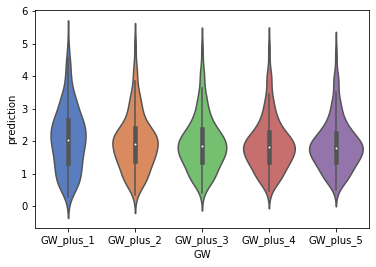

In [40]:
sns.violinplot(x="GW", y="prediction", data=plot_df, palette="muted", split=True)
plt.show()

In [41]:
top100_prediction_players = list(final_predictions.head(100)['name'])

## SHAP values

### Feature importance

In [43]:
player_data_list[0].shape

(5, 62)

In [44]:
player_data_list[0]

,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points
36,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.972973,0.0,0.035433,0.047246,0.0,0.0,0.0,0.051159,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
37,0.167,0.0,0.181818,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,0.2,0.125,0.333333,0.009524,0.289954,0.0,0.0,0.0,0.494444,0.200000,0.218650,0.70,1.00,0.71,0.065789,0.013889,0.0,0.0,0.00000,0.0,0.333,0.250,0.222222,0.5,0.0,1.0,0.000000,0.055556,1.0,0.0,0.494444,0.121739,0.250000,0.0,1.000000,0.0,0.118898,0.014746,0.5,0.0,0.5,0.149564,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.322581
38,0.000,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.250,0.000000,0.000000,0.077626,0.0,0.0,0.0,0.000000,0.211111,0.067524,1.00,1.00,1.00,0.000000,0.013889,0.0,0.0,0.00000,0.0,0.333,0.125,0.111111,0.0,0.5,0.0,0.000000,0.111111,0.0,0.0,0.250000,0.104348,0.083333,0.0,0.000000,0.0,0.022047,0.046946,0.0,0.0,0.0,0.055673,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.161290
39,0.286,0.0,0.181818,0.0,0.333333,0.0,0.5,0.0,0.0,0.0,0.5,0.285714,0.2,0.000,0.000000,0.052381,0.157534,0.0,0.0,0.0,0.494444,0.200000,0.035370,0.77,0.83,0.67,0.065789,0.034722,0.0,0.0,0.06250,0.0,0.500,0.000,0.111111,0.5,0.0,1.0,0.000000,0.111111,0.5,0.0,0.494444,0.121739,0.125000,0.0,0.027027,0.0,0.099213,0.017153,0.5,0.0,0.5,0.130304,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.322581
40,0.000,0.0,0.363636,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.250,0.000000,0.057143,0.043379,0.0,0.0,0.0,0.000000,0.255556,0.012862,0.86,1.00,1.00,0.052632,0.013889,0.0,0.0,0.03125,0.0,0.000,0.000,0.000000,0.5,0.0,0.0,0.090909,0.000000,0.0,0.0,0.411111,0.095652,0.125000,0.0,0.054054,0.0,0.055906,0.022570,0.0,0.0,0.0,0.108637,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.193548


In [45]:
input_data_columns = list(player_data_list[0].columns)

In [46]:
# Order of columns after reshaping to 2D
input_data_columns_flattened = \
    [col + '_minus5' for col in input_data_columns] + \
    [col + '_minus4' for col in input_data_columns] + \
    [col + '_minus3' for col in input_data_columns] + \
    [col + '_minus2' for col in input_data_columns] + \
    [col + '_minus1' for col in input_data_columns]

In [47]:
flattened_df = pd.DataFrame(
    player_data_list[0].values.reshape(1, -1),
    columns=input_data_columns_flattened
)

flattened_df

,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

In [48]:
reconstructed_df = pd.DataFrame(
    flattened_df.values.reshape(5, -1),
    columns=input_data_columns
)

reconstructed_df

,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points
0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.972973,0.0,0.035433,0.047246,0.0,0.0,0.0,0.051159,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
1,0.167,0.0,0.181818,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,0.2,0.125,0.333333,0.009524,0.289954,0.0,0.0,0.0,0.494444,0.200000,0.218650,0.70,1.00,0.71,0.065789,0.013889,0.0,0.0,0.00000,0.0,0.333,0.250,0.222222,0.5,0.0,1.0,0.000000,0.055556,1.0,0.0,0.494444,0.121739,0.250000,0.0,1.000000,0.0,0.118898,0.014746,0.5,0.0,0.5,0.149564,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.322581
2,0.000,0.0,0.090909,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.250,0.000000,0.000000,0.077626,0.0,0.0,0.0,0.000000,0.211111,0.067524,1.00,1.00,1.00,0.000000,0.013889,0.0,0.0,0.00000,0.0,0.333,0.125,0.111111,0.0,0.5,0.0,0.000000,0.111111,0.0,0.0,0.250000,0.104348,0.083333,0.0,0.000000,0.0,0.022047,0.046946,0.0,0.0,0.0,0.055673,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.161290
3,0.286,0.0,0.181818,0.0,0.333333,0.0,0.5,0.0,0.0,0.0,0.5,0.285714,0.2,0.000,0.000000,0.052381,0.157534,0.0,0.0,0.0,0.494444,0.200000,0.035370,0.77,0.83,0.67,0.065789,0.034722,0.0,0.0,0.06250,0.0,0.500,0.000,0.111111,0.5,0.0,1.0,0.000000,0.111111,0.5,0.0,0.494444,0.121739,0.125000,0.0,0.027027,0.0,0.099213,0.017153,0.5,0.0,0.5,0.130304,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.322581
4,0.000,0.0,0.363636,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.250,0.000000,0.057143,0.043379,0.0,0.0,0.0,0.000000,0.255556,0.012862,0.86,1.00,1.00,0.052632,0.013889,0.0,0.0,0.03125,0.0,0.000,0.000,0.000000,0.5,0.0,0.0,0.090909,0.000000,0.0,0.0,0.411111,0.095652,0.125000,0.0,0.054054,0.0,0.055906,0.022570,0.0,0.0,0.0,0.108637,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.193548


In [49]:
# Check reconstructed data:
for col in input_data_columns:
    np.testing.assert_array_equal(
        player_data_list[0][col],
        reconstructed_df[col]
    )

__Create input array for LSTM by doing above steps for all DataFrames in `player_data_list`__

In [50]:
player_data_flattened_list = [
    pd.DataFrame(
        df.values.reshape(1, -1),
        columns=input_data_columns_flattened
    ) 
    for df in player_data_list
]

player_data_flattened_df = pd.concat(player_data_flattened_list, ignore_index=True)
print(player_data_flattened_df.shape)
player_data_flattened_df.head()

(279, 310)


,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

In [51]:
# Array passed to SHAP functions
lstm_input_array = player_data_flattened_df.values

__Check reconstruction of data from `lstm_input_array`__

In [52]:
player_data_list_reconstructed_test = [
    pd.DataFrame(
        input_array.reshape(5, -1),
        columns=input_data_columns
    ) 
    for input_array 
    in np.array_split(  # Split array into individual flat row arrays
        lstm_input_array,
        lstm_input_array.shape[0]
    )
]

In [53]:
len(player_data_list_reconstructed_test)

279

In [54]:
# Check reconstructed data
reconstructed_concat = pd.concat(player_data_list_reconstructed_test, ignore_index=True)
original_concat = pd.concat(player_data_list, ignore_index=True)

for col in input_data_columns:
    np.testing.assert_array_equal(
        reconstructed_concat[col],
        original_concat[col]
    )

__Create wrapper function around `lstm_pred.make_player_predictions`__

In [55]:
def make_predictions(input_array_2d):
    """
    Wrapper around make_player_predictions which includes the additional step of converting the 2D input array to a list of 3D arrays for each player.
    """
    # 2D input array to list of 3D arrays:
    player_data_list_reconstructed = [
        pd.DataFrame(
            input_array.reshape(5, -1),
            columns=input_data_columns
        ) 
        for input_array 
        in np.array_split(
            input_array_2d,
            input_array_2d.shape[0]
        )
    ]
    
    # Make predictions:
    raw_predictions = lstm_pred.make_player_predictions(
        player_data_list=player_data_list_reconstructed
    )
    
    return raw_predictions['GW_plus_1']

In [56]:
# Test function
make_predictions(lstm_input_array)

2020-10-02 16:06:31,630 - LSTM input array shape: (279, 5, 62)


0      2.058220
1      1.862278
2      2.023173
3      1.634931
4      1.345390
         ...   
274    2.798199
275    1.973793
276    2.413186
277    2.900606
278    0.886509
Name: GW_plus_1, Length: 279, dtype: float32

In [57]:
lstm_input_array.shape

(279, 310)

In [58]:
lstm_input_array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.19354839],
       [0.333     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.32258065],
       [1.        , 0.        , 0.09090909, ..., 0.        , 1.        ,
        0.16129032],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.19354839],
       [1.        , 0.        , 0.18181818, ..., 1.        , 1.        ,
        0.32258065],
       [0.5       , 0.        , 0.        , ..., 1.        , 0.        ,
        0.12903226]])

In [59]:
np.random.seed(RANDOM_SEED)
idx = np.random.randint(lstm_input_array.shape[0], size=100)  # Use 100 random examples in background data
idx

array([152, 249, 131, 256, 277, 147, 202, 169, 138, 119, 148,  93,  26,
       150, 258, 129,  69, 110,  97, 106, 152,   7, 171,  33, 176,  20,
        49, 206,  28,  54,   0, 192, 274, 165, 184, 165, 253, 174,  33,
       113,   1, 117, 235,  99, 219, 160, 274, 183, 223, 141,  48, 242,
         2, 156,  36, 232, 172, 176, 182,  91, 277, 113, 104, 160, 176,
         9,  33, 216, 267, 212, 208,  76,  44, 275, 120, 226, 167, 178,
        35, 173, 242,  52, 257, 274,   2, 215, 148,  62,  22, 135,  32,
       252,  92,   8, 276, 264, 152,  76,  19, 100])

In [60]:
background_data = lstm_input_array[idx, :]
background_data.shape

(100, 310)

In [61]:
explainer = shap.KernelExplainer(make_predictions, background_data.astype(np.float32))

2020-10-02 16:06:34,529 - LSTM input array shape: (100, 5, 62)


In [62]:
# Turn off logs
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [63]:
lstm_input_array.shape

(279, 310)

## Top 100 players

### Aggregate view

In [48]:
player_idx_list = []

for player in top100_prediction_players:
    player_idx = player_list.index(player)
    player_idx_list.append(player_idx)

In [49]:
top100_input_data = lstm_input_array[player_idx_list, :]

In [50]:
top100_input_data.shape

(100, 310)

In [51]:
top100_input_data

array([[1.        , 0.        , 0.27272727, ..., 1.        , 1.        ,
        0.22580645],
       [0.25      , 0.        , 0.09090909, ..., 1.        , 1.        ,
        0.29032258],
       [1.        , 0.        , 0.09090909, ..., 1.        , 1.        ,
        0.4516129 ],
       ...,
       [0.667     , 0.        , 0.27272727, ..., 0.        , 0.        ,
        0.19354839],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.35483871],
       [0.667     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12903226]])

In [52]:
%%time
shap_values = explainer.shap_values(
    top100_input_data.astype(np.float32)
)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

KeyboardInterrupt: 

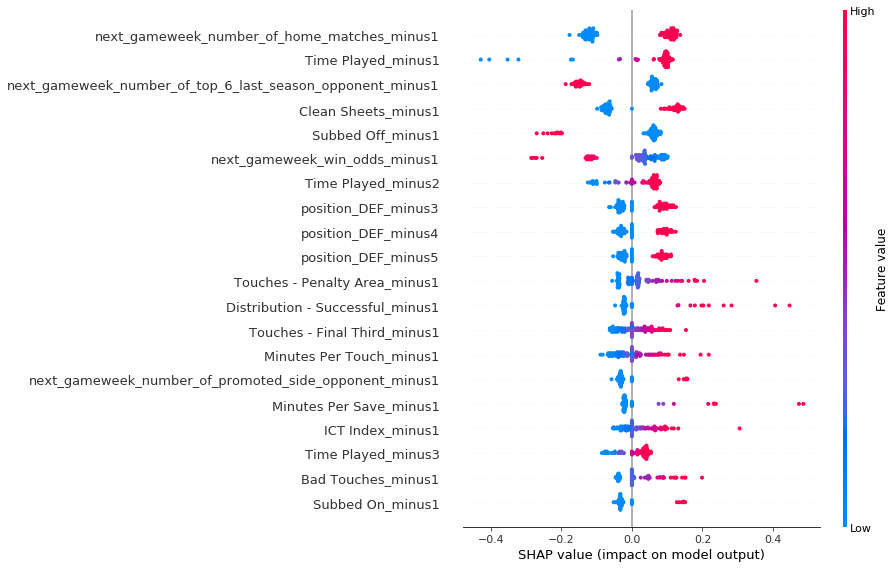

In [49]:
shap.summary_plot(
    shap_values,
    features=top100_input_data.astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [50]:
shap_values.shape

(100, 310)

In [51]:
len(input_data_columns_flattened)

310

In [52]:
shap_df = pd.DataFrame(shap_values, columns=input_data_columns_flattened)
shap_df.head()

,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

Feature importance is the ranking of mean absolute SHAP values for each feature

In [53]:
np.abs(shap_df).mean().sort_values(ascending=False)

next_gameweek_number_of_home_matches_minus1                  0.116108
Time Played_minus1                                           0.104016
next_gameweek_number_of_top_6_last_season_opponent_minus1    0.095219
Clean Sheets_minus1                                          0.090537
Subbed Off_minus1                                            0.079397
                                                               ...   
Premier League Total Red Cards_minus3                        0.000000
Premier League Total Red Cards_minus2                        0.000000
Premier League Straight Red Cards_minus2                     0.000000
gw_minus5                                                    0.000000
double_gameweek_minus2                                       0.000000
Length: 310, dtype: float64

Plot feature importance using all time periods of feature

In [54]:
shap_df = shap_df.T.reset_index().rename(columns={'index': 'time_feature'})
shap_df.head()

,time_feature,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,Aerial Duels - Won - Percentage_minus5,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.010209,0.017509,0.0,0.0,0.0,-0.002834,0.000000,0.0,0.000000,0.000000,0.000000,0.000237,0.0,0.000000,0.020503,0.000000,0.000000,0.000000,0.000000,0.0,0.008213,0.000000,0.0,0.000000,-0.004706,0.006294,0.000000,0.000000,0.000000,0.000000,0.000000,0.010263,-0.005743,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.007272,0.000000,0.000000,-0.001100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004356,0.000000,-0.003523,0.001490,0.002341,0.002959,0.00000,-0.005648,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.006296,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004545,0.0,0.0,0.002743,0.002964,0.000000,-0.003228,-0.001702,0.000000,0.000000,0.010686,0.0,-0.005740,0.000000,0.000000
1,Assists_minus5,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.006527,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.003667,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.000111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001574,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.001828,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.002075,0.000000,0.000000,0.000000,0.0,0.000187,0.000000,0.000000
2,Bad Touches_minus5,0.006365,0.000000,0.000000,0.0,0.015915,0.032201,0.0,0.021827,0.0,0.0,-0.006804,-0.009845,0.0,0.0,0.0,0.000000,0.062001,0.0,0.000000,0.047980,-0.012758,0.005512,0.0,0.030648,-0.014548,0.041670,0.000000,0.041832,0.000000,0.0,0.000000,0.008617,0.0,0.018161,0.000000,0.033363,-0.013268,-0.009736,-0.006450,0.031216,0.005106,0.030937,-0.007792,0.0,0.000000,0.018584,0.031562,-0.008471,0.000000,0.004081,0.014012,-0.008512,-0.006954,-0.008858,0.016667,0.000000,-0.009974,0.000000,0.024532,0.000000,-0.009610,-0.007515,0.000000,-0.008458,0.016165,-0.007701,-0.01143,0.000000,0.000000,0.0,0.0,-0.013575,0.015327,0.004396,0.032117,0.004837,0.000000,0.019697,0.0,-0.009280,-0.013876,0.000000,0.091646,0.039594,-0.008560,-0.009454,0.0,0.0,-0.009576,0.000000,-0.008313,-0.007292,-0.012980,-0.007722,0.019184,-0.010303,0.0,-0.013216,0.000000,-0.006646
3,Big Chances Created_minus5,0.000000,0.000000,0.000000,0.0,0.013491,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.013055,0.014594,0.000000,0.000000,0.0,0.000000,0.000000,-0.004949,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.001599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.002669,0.000000,0.000000,0.000000,0.029490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000949,0.000000,0.000000,-0.002191,0.000000,0.000000,0.030948,0.000000,0.000000,0.00000,0.000000,-0.002404,0.0,0.0,-0.007203,0.000000,0.000000,0.016827,-0.005458,0.000000,0.000000,0.0,0.026544,0.000000,0.000000,-0.003841,0.000000,0.024498,-0.003052,0.0,0.0,0.000000,0.000000,0.000000,-0.003325,-0.003241,0.000000,0.000000,0.000000,0.0,-0.004804,0.015819,0.000000
4,Caught Offside_minus5,0.000000,0.065901,0.006563,0.0,0.059153,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007083,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000

In [55]:
shap_df['feature'] = shap_df['time_feature'].str.rsplit('_', 1).apply(lambda x: x[0])

1. Groupby feature, sum SHAP values
2. Take mean of _absolute_ SHAP values for each feature
3. Sort

In [56]:
feature_importance = np.abs(
    shap_df.groupby('feature').sum()
).T.mean().sort_values(ascending=False)

feature_importance

feature
Time Played                             0.190416
position_DEF                            0.165744
position_MID                            0.128185
Touches - Final Third                   0.125641
next_gameweek_number_of_home_matches    0.124977
                                          ...   
Handballs                               0.002459
Premier League Total Red Cards          0.002096
double_gameweek                         0.001731
next_gameweek_double_gameweek           0.000318
gw                                      0.000000
Length: 62, dtype: float64

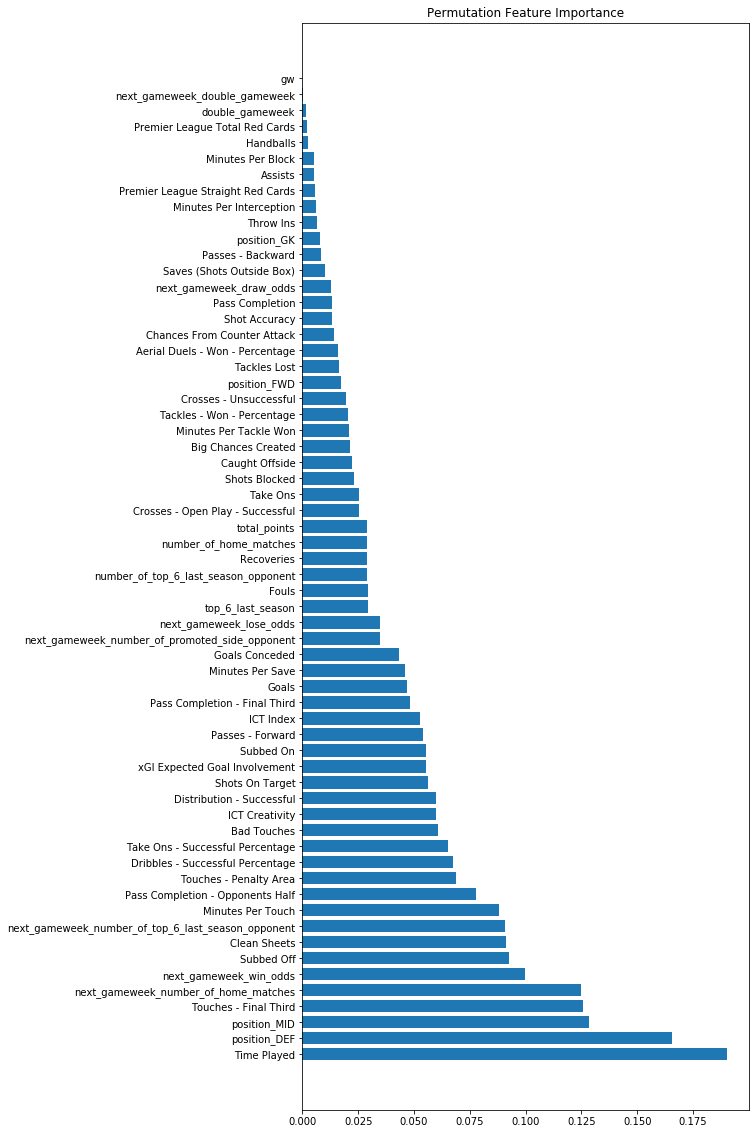

In [57]:
plt.figure(figsize=(8, 20))
plt.barh(
    feature_importance.index, 
    feature_importance.values
)
plt.title('Permutation Feature Importance')
plt.show()

### Individual player predictions

In [58]:
shap_values.shape

(100, 310)

In [59]:
top100_prediction_players

['mohamed_salah',
 'harry_kane',
 'jamie_vardy',
 'andrew_robertson',
 'sadio_mane',
 'pierre-emerick_aubameyang',
 'hugo_lloris',
 'heung-min_son',
 'rui_pedro dos santos patrício',
 'michail_antonio',
 'virgil_van dijk',
 'alisson_ramses becker',
 'kasper_schmeichel',
 'danny_ings',
 'raul_alonso jimenez rodriguez',
 'alex_mccarthy',
 'roberto_firmino barbosa de oliveira',
 'jordan_pickford',
 'nathan_redmond',
 'wilfried_zaha',
 'mathew_ryan',
 'georginio_wijnaldum',
 'willian_borges da silva',
 'harvey_barnes',
 'kepa_arrizabalaga revuelta',
 'joseph_gomez',
 'romain_saiss',
 'mason_mount',
 'caglar_söyüncü',
 'alexandre_lacazette',
 'toby_alderweireld',
 'jonjo_shelvey',
 'richarlison_de andrade',
 'marcos_alonso',
 'trent_alexander-arnold',
 'james_ward-prowse',
 'ben_davies',
 'leandro_trossard',
 'lukasz_fabianski',
 'kieran_tierney',
 'jake_livermore',
 'kyle_walker-peters',
 'vicente_guaita',
 'george_baldock',
 'reece_james',
 'james_justin',
 'youri_tielemans',
 'kurt_zouma',
 'lucas_rodrigues moura da silva',
 'tomas_soucek',
 'daniel_castelo podence',
 'rob_holding',
 'enda_stevens',
 'héctor_bellerín',
 'che_adams',
 'neal_maupay',
 'conor_coady',
 'tariq_lamptey',
 'dominic_calvert-lewin',
 'michael_keane',
 'john_lundstram',
 'willy_boly',
 'jeff_hendrick',
 'federico_fernández',
 'aaron_connolly',
 'john_egan',
 'césar_azpilicueta',
 'billy_sharp',
 'andros_townsend',
 'lucas_digne',
 'scott_dann',
 'ainsley_maitland-niles',
 'adam_webster',
 'declan_rice',
 'david_mcgoldrick',
 'lewis_dunk',
 'matt_doherty',
 'ayoze_pérez gutiérrez',
 'mark_noble',
 'issa_diop',
 'bernd_leno',
 'adama_traoré',
 'allan_saint-maximin',
 'nicolas_pepe',
 'ryan_fredericks',
 'pierre-emile_højbjerg',
 'jorge_luiz frello filho',
 'jordan_ayew',
 'jack_stephens',
 "jack_o'connell",
 'jannik_vestergaard',
 'solomon_march',
 'mohamed_elneny',
 'john_fleck',
 'miguel_almirón',
 'leander_dendoncker',
 'seamus_coleman',
 'eric_dier',
 'joe_bryan',
 'oliver_mcburnie']

In [60]:
explainer.expected_value

2.3366583633422855

In [107]:
top100_idx = top100_prediction_players.index('james_ward-prowse')
top100_idx

35

In [108]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values[top100_idx, :], 
    lstm_input_array[player_idx_list[top100_idx], :].astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [109]:
player_shap_values = pd.DataFrame(
    shap_values[top100_idx, :].reshape(1, 310), 
    columns=input_data_columns_flattened
).T.reset_index().rename(
    columns={
        'index': 'feature_at_time', 
        0:'shap_value'
    }
)

player_shap_values.sort_values('shap_value', ascending=False, inplace=True)
player_shap_values

,feature_at_time,shap_value
298,next_gameweek_number_of_home_matches_minus1,0.108422
290,Time Played_minus1,0.096756
77,ICT Creativity_minus4,0.083724
105,Touches - Final Third_minus4,0.076082
158,Shots On Target_minus3,0.068964
...,...,...
211,Pass Completion - Opponents Half_minus2,-0.050275
130,Clean Sheets_minus3,-0.057566
164,Take Ons - Successful Percentage_minus3,-0.059982
254,Clean Sheets_minus1,-0.066825


In [110]:
player_shap_values['feature'] = player_shap_values['feature_at_time'].str.rsplit('_', 1).apply(lambda x: x[0])

In [111]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).head(20)

,shap_value
feature,
Time Played,0.278695
Touches - Final Third,0.251537
ICT Creativity,0.180704
next_gameweek_number_of_home_matches,0.125423
position_MID,0.124250
xGI Expected Goal Involvement,0.089769
Subbed Off,0.080466
Shots On Target,0.074274
ICT Index,0.067953


In [112]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).sum() + 3.84

shap_value    4.331396
dtype: float64

In [114]:
top100_idx = top100_prediction_players.index('michail_antonio')
top100_idx

9

In [115]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values[top100_idx, :], 
    lstm_input_array[player_idx_list[top100_idx], :].astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [116]:
player_shap_values = pd.DataFrame(
    shap_values[top100_idx, :].reshape(1, 310), 
    columns=input_data_columns_flattened
).T.reset_index().rename(
    columns={
        'index': 'feature_at_time', 
        0:'shap_value'
    }
)

player_shap_values.sort_values('shap_value', ascending=False, inplace=True)
player_shap_values

,feature_at_time,shap_value
22,xGI Expected Goal Involvement_minus5,0.321605
34,Shots On Target_minus5,0.209489
12,Goals_minus5,0.161137
292,Touches - Penalty Area_minus1,0.160724
5,Chances From Counter Attack_minus5,0.140617
...,...,...
73,Fouls_minus4,-0.064335
221,Subbed Off_minus2,-0.078655
115,next_gameweek_win_odds_minus4,-0.091277
301,next_gameweek_win_odds_minus1,-0.123540


In [117]:
player_shap_values['feature'] = player_shap_values['feature_at_time'].str.rsplit('_', 1).apply(lambda x: x[0])

In [118]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).head(20)

,shap_value
feature,
xGI Expected Goal Involvement,0.483234
Shots On Target,0.327428
Touches - Penalty Area,0.250251
Goals,0.234020
Touches - Final Third,0.233660
ICT Index,0.173624
Time Played,0.169250
Dribbles - Successful Percentage,0.135918
Chances From Counter Attack,0.115141


In [119]:
# live_data[
#     (live_data['name'] == 'trent_alexander-arnold') & 
#     (live_data['gw'] > PREVIOUS_GW-5) & 
#     (live_data['season_order'] == PREDICTION_SEASON_ORDER)
# ]['Subbed On']

### Players outside top 100

### TODO Make this the primary cells to run (often look at individuals rather than top 100 as a whole)
### TODO Add SHAP for total points prediction as well as next GW

In [64]:
set(live_data['team_name'])

{'Arsenal',
 'Aston Villa',
 'Blackburn Rovers',
 'Bolton Wanderers',
 'Brighton and Hove Albion',
 'Burnley',
 'Cardiff City',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Huddersfield Town',
 'Hull City',
 'Leicester City',
 'Liverpool',
 'Manchester City',
 'Manchester United',
 'Middlesbrough',
 'Newcastle United',
 'Queens Park Rangers',
 'Reading',
 'Sheffield United',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Tottenham Hotspur',
 'West Bromwich Albion',
 'West Ham United',
 'Wigan Athletic',
 'Wolverhampton Wanderers'}

In [65]:
live_data[live_data['team_name'] == 'Aston Villa']['name'].unique()

array(['adama_traoré', 'ahmed_elmohamady', 'alan_hutton',
       'aleksandar_tonev', 'aly_cissokho', 'andre_green',
       'andreas_weimann', 'antonio_luna', 'anwar_el ghazi',
       'ashley_roy westwood', 'barry_bannan', 'bertrand_traore',
       'björn_engels', 'borja_gonzález tomás', 'brad_guzan',
       'brett_holman', 'callum_robinson', 'carles_gil de pareja vicent',
       'carlos_cuéllar', 'carlos_sánchez', 'charles_n&amp;#39;zogbia',
       'chris_herd', 'christian_benteke', 'ciaran_clark',
       'conor_hourihane', 'darren_bent', 'derrick_williams',
       'douglas_luiz soares de paulo', 'emile_heskey',
       'emiliano_martinez', 'enda_stevens', 'eric_lichaj',
       'ezri_konsa ngoyo', 'fabian_delph', 'frederic_guilbert',
       'gabriel_agbonlahor', 'gary_gardner', 'grant_holt',
       'henri_lansbury', 'idrissa_gueye', 'indiana_vassilev',
       'jack_grealish', 'jacob_ramsey', 'james_collins', 'jed_steer',
       'joe_bennett', 'joe_cole', 'john_mcginn', 'joleon_lescott',

In [84]:
ozil_idx = player_list.index('dominic_calvert-lewin')
ozil_idx

66

In [85]:
shap_values_ozil = explainer.shap_values(
    lstm_input_array[ozil_idx, :].astype(np.float32)
)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [86]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values_ozil, 
    lstm_input_array[ozil_idx, :].astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [77]:
# live_data[
#     (live_data['name'] == 'gabriel_fernando de jesus') & 
#     (live_data['gw'] > PREVIOUS_GW-5) & 
#     (live_data['season_order'] == PREDICTION_SEASON_ORDER)
# ]

In [87]:
player_shap_values = pd.DataFrame(
    shap_values_ozil.reshape(1, 310), 
    columns=input_data_columns_flattened
).T.reset_index().rename(
    columns={
        'index': 'feature_at_time', 
        0:'shap_value'
    }
)

player_shap_values.sort_values('shap_value', ascending=False, inplace=True)
player_shap_values

,feature_at_time,shap_value
198,Goals_minus2,0.179835
290,Time Played_minus1,0.169482
250,Bad Touches_minus1,0.156383
202,ICT Index_minus2,0.152196
260,Goals_minus1,0.142943
...,...,...
305,position_FWD_minus1,-0.055062
159,Subbed Off_minus3,-0.069282
164,Take Ons - Successful Percentage_minus3,-0.069378
98,Subbed On_minus4,-0.092647


In [88]:
player_shap_values.head(20)

,feature_at_time,shap_value
198,Goals_minus2,0.179835
290,Time Played_minus1,0.169482
250,Bad Touches_minus1,0.156383
202,ICT Index_minus2,0.152196
260,Goals_minus1,0.142943
220,Shots On Target_minus2,0.112495
208,xGI Expected Goal Involvement_minus2,0.109859
298,next_gameweek_number_of_home_matches_minus1,0.092483
301,next_gameweek_win_odds_minus1,0.077185
292,Touches - Penalty Area_minus1,0.075147


In [89]:
player_shap_values.tail(20)

,feature_at_time,shap_value
112,next_gameweek_number_of_home_matches_minus4,0.000000
111,next_gameweek_lose_odds_minus4,0.000000
110,next_gameweek_draw_odds_minus4,0.000000
109,next_gameweek_double_gameweek_minus4,0.000000
108,gw_minus4,0.000000
99,Tackles - Won - Percentage_minus4,0.000000
155,Saves (Shots Outside Box)_minus3,0.000000
105,Touches - Final Third_minus4,0.000000
104,Time Played_minus4,0.000000
103,Throw Ins_minus4,0.000000


In [90]:
player_shap_values['feature'] = player_shap_values['feature_at_time'].str.rsplit('_', 1).apply(lambda x: x[0])

In [91]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).head(20)

,shap_value
feature,
Goals,0.346864
Shots On Target,0.240567
ICT Index,0.220546
Time Played,0.173204
Minutes Per Touch,0.158842
Bad Touches,0.156383
Touches - Penalty Area,0.134896
xGI Expected Goal Involvement,0.116730
next_gameweek_number_of_home_matches,0.114465


## Save top 100 SHAP values for later use

In [81]:
top100_shap_dict = {
    'top100_prediction_players': top100_prediction_players,
    'shap_values': shap_values,
    'explainer': explainer,
    'lstm_input_array': lstm_input_array,
    'input_data_columns_flattened': input_data_columns_flattened
}

In [82]:
import pickle

In [83]:
pickle.dump(top100_shap_dict, open('top100_shap_dict.pickle', 'wb'))

In [84]:
from src.models.utils import _load_model_from_pickle

In [85]:
test = _load_model_from_pickle('top100_shap_dict.pickle')

In [86]:
test['explainer'].expected_value

2.3366583633422855